# Load Data

In [ ]:
import pandas as pd
import numpy as np

# Definisikan path file
path = '/content/drive/MyDrive/Colab Notebooks/RisetHibahPemerintah/Eksperimen - Klasifikasi Teks/Eksperimen dengan Algoritma GB/'

data = pd.read_csv(path + 'Salinan datamodel_klasifikasi_clean.csv')
df = data[['Answer_fix', 'topik']].copy()

In [ ]:
df['Answer_fix'] = df['Answer_fix'].apply(eval)  # Konversi string list ke list

In [ ]:
df.head()

,Answer_fix,topik
0,"[insomnia, sakit, gejala, sakit, sakit, mental...",depresi
1,"[asa, debar, debar, irama, jantung, atur, otot...",stres
2,"[paham, asa, anak, tua, cerai, mudah, terkadan...",depresi
3,"[maria, prihatin, kondisi, alami, pengaruh, am...",depresi
4,"[depresi, bentuk, mental, perhati, masyarakat,...",depresi


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Ekstraksi fitur menggunakan N-Gram pada data yang sudah ditokenisasi
ngram_vectorizer = CountVectorizer(ngram_range=(1, 2), tokenizer=lambda x: x, lowercase=False, max_features=100)
X_ngram = ngram_vectorizer.fit_transform(df['Answer_fix'])

# Setting data
nama_ekstraksi = 'X_ngram'
fitur = X_ngram
y = df['topik']

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# import modul

In [ ]:
!pip install sklearn-genetic-opt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 8.3 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
import json
import nltk

# Pastikan nltk sudah terinstall
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous

In [ ]:
import joblib
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn_genetic")
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Ganti backend joblib
joblib.parallel_backend('threading')

# Setel variabel lingkungan untuk joblib
os.environ['JOBLIB_TEMP_FOLDER'] = '/tmp'
os.environ['JOBLIB_PARALLEL_BACKEND'] = 'threading'

# BC SplitV modelling

In [ ]:
# Define models
models = {
    'Gradient Boosting': GradientBoostingClassifier()
    }

# Bagging classifier
optimasi = 'BC optimization'
def get_bagging_clf(base_estimator):
    return BaggingClassifier(estimator=base_estimator, n_estimators=10, random_state=42, n_jobs=-1)

In [ ]:
# Define split ratios
splits = [(0.6, 0.4), (0.7, 0.3), (0.8, 0.2), (0.9, 0.1)]

# Initialize results dictionary
results = {}

for train_size, test_size in splits:
    print(f'Processing split {int(train_size*100)}:{int(test_size*100)}')

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(fitur, y, test_size=test_size, random_state=42)

    for model_name, model in models.items():
        print(f'  Training {model_name} with Bagging Classifier')

        # Create Bagging Classifier with the current model
        bagging_clf = get_bagging_clf(model)
        bagging_clf.fit(X_train, y_train)
        y_pred = bagging_clf.predict(X_test)

        # Evaluation
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)

        # Convert tuple key to string
        result_key = f"{model_name}_{optimasi}_split {int(train_size*100)}:{int(test_size*100)}"

        # Save results
        results[result_key] = {
            'confusion_matrix': conf_matrix.tolist(),
            'classification_report': class_report,
            'accuracy': accuracy
        }

        print(f'    Accuracy: {accuracy:.4f}')
        print('    Classification Report:')
        print(classification_report(y_test, y_pred, zero_division=0))

# Save results to a JSON file
with open(path + f'{nama_ekstraksi}_bc_sv_experiment_results.json', 'w') as f:
    json.dump(results, f, indent=4)

Processing split 60:40
  Training Gradient Boosting with Bagging Classifier
    Accuracy: 0.8340
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.82      0.79      0.81       397
     depresi       0.83      0.88      0.85       591
       stres       0.84      0.82      0.83       506

    accuracy                           0.83      1494
   macro avg       0.83      0.83      0.83      1494
weighted avg       0.83      0.83      0.83      1494

Processing split 70:30
  Training Gradient Boosting with Bagging Classifier
    Accuracy: 0.8368
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.82      0.79      0.80       304
     depresi       0.85      0.87      0.86       439
       stres       0.84      0.84      0.84       378

    accuracy                           0.84      1121
   macro avg       0.83      0.83      0.83      1121
weighted avg       0.84      0.84      0.84  

## Menampilkan hasil model

In [ ]:
import json

# Membaca file JSON
with open(path + f'{nama_ekstraksi}_bc_sv_experiment_results.json', 'r') as f:
    results = json.load(f)

### Confusion Matrix (heatmap)

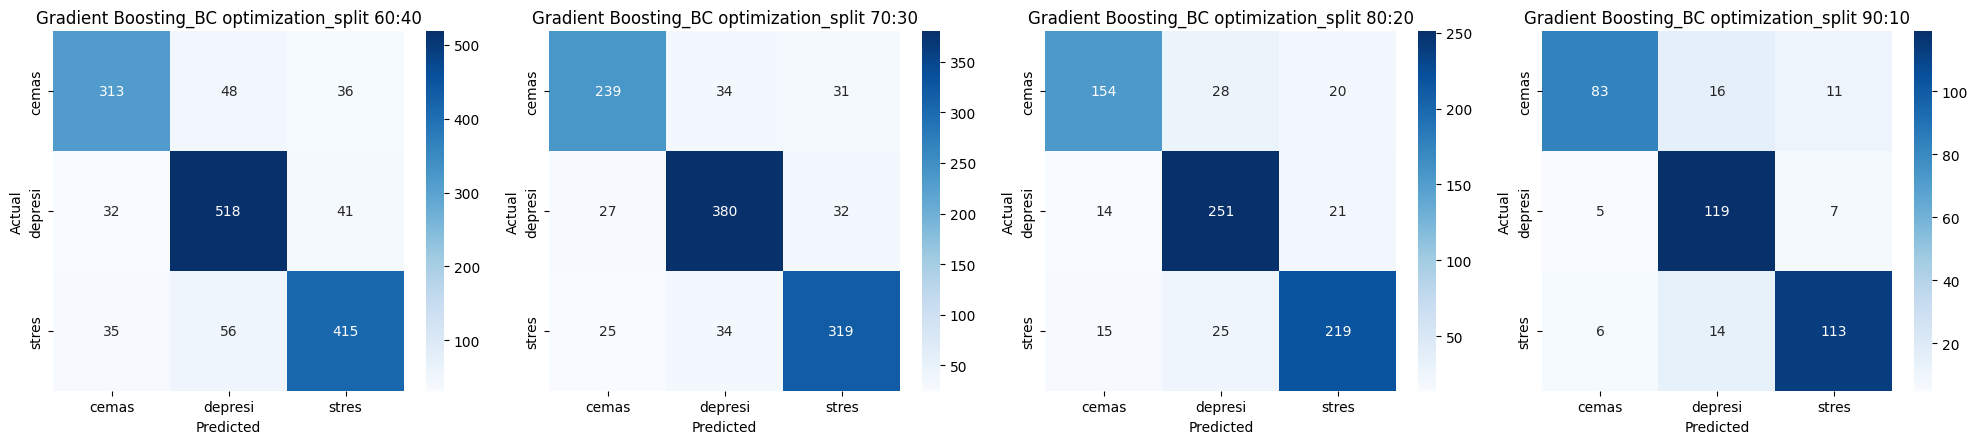

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Set the figure size
plt.rcParams['figure.figsize'] = [20, 25]

# Create subplots for each confusion matrix
for i, (key, value) in enumerate(results.items()):
    cm = np.array(value['confusion_matrix'])
    plt.subplot(6, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(key)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.axis("on")

# Show the plots
plt.tight_layout()
plt.show()

### Evaluasi kinerja model

In [ ]:
# Inisialisasi list untuk menyimpan data
data = []

# Ekstrak split dan model dari keys di results
for key, value in results.items():
    model_name, split_info = key.split(f'_BC optimization_split')
    split_ratio = split_info.replace('_test', ':')
    accuracy = value['accuracy']

    # Tambahkan data ke dalam list
    data.append([split_ratio, model_name, accuracy])

# Konversi list ke DataFrame
accuracy_table = pd.DataFrame(data, columns=['Split', 'Model', 'Accuracy'])

# Pivot DataFrame agar model menjadi kolom
accuracy_table = accuracy_table.pivot(index='Split', columns='Model', values='Accuracy')

# Atur ulang kolom sesuai urutan yang diinginkan
accuracy_table = accuracy_table[['Gradient Boosting']]

# Tampilkan tabel akurasi
accuracy_table

Model,Gradient Boosting
Split,
60:40,0.834003
70:30,0.836753
80:20,0.835341
90:10,0.842246


In [ ]:
# Initialize an empty list to store data for the DataFrame
data = []

# Extracting data for each model and split
for experiment_name, result in results.items():
    for label, metrics in result['classification_report'].items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip overall metrics
            row = {
                'Experiment': experiment_name,
                'Label': label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            }
            data.append(row)

# Create DataFrame from the data list
df_results = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df_results

,Experiment,Label,Precision,Recall,F1-Score,Support
0,Gradient Boosting_BC optimization_split 60:40,cemas,0.823684,0.788413,0.805663,397.0
1,Gradient Boosting_BC optimization_split 60:40,depresi,0.832797,0.876481,0.854081,591.0
2,Gradient Boosting_BC optimization_split 60:40,stres,0.843496,0.820158,0.831663,506.0
3,Gradient Boosting_BC optimization_split 70:30,cemas,0.821306,0.786184,0.803361,304.0
4,Gradient Boosting_BC optimization_split 70:30,depresi,0.848214,0.865604,0.856821,439.0
5,Gradient Boosting_BC optimization_split 70:30,stres,0.835079,0.843915,0.839474,378.0
6,Gradient Boosting_BC optimization_split 80:20,cemas,0.841530,0.762376,0.800000,202.0
7,Gradient Boosting_BC optimization_split 80:20,depresi,0.825658,0.877622,0.850847,286.0
8,Gradient Boosting_BC optimization_split 80:20,stres,0.842308,0.845560,0.843931,259.0
9,Gradient Boosting_BC optimization_split 90:10,cemas,0.882979,0.754545,0.813725,110.0


### Simpan ke Excel

In [ ]:
import pandas as pd
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Initialize an empty DataFrame to store all confusion matrices
df_cm_combined = pd.DataFrame()

# Loop through each model and its confusion matrix in the results
for key, value in results.items():
    # Extract the confusion matrix
    cm = np.array(value['confusion_matrix'])

    # Create a DataFrame from the confusion matrix
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)

    # Insert the model name into the first column, with only the first row showing the model name
    df_cm.insert(0, 'Model', [key] + [''] * (len(labels) - 1))

    # Concatenate this confusion matrix DataFrame with the combined DataFrame
    df_cm_combined = pd.concat([df_cm_combined, df_cm])

# Display the combined DataFrame
df_cm_combined

,Model,cemas,depresi,stres
cemas,Gradient Boosting_BC optimization_split 60:40,313,48,36
depresi,,32,518,41
stres,,35,56,415
cemas,Gradient Boosting_BC optimization_split 70:30,239,34,31
depresi,,27,380,32
stres,,25,34,319
cemas,Gradient Boosting_BC optimization_split 80:20,154,28,20
depresi,,14,251,21
stres,,15,25,219
cemas,Gradient Boosting_BC optimization_split 90:10,83,16,11


In [ ]:
# Group by 'Experiment' and calculate the mean of only the numeric columns
df_overall_result = df_results.groupby('Experiment')[['Precision', 'Recall', 'F1-Score']].mean().reset_index()

# Display the overall result DataFrame
df_overall_result

,Experiment,Precision,Recall,F1-Score
0,Gradient Boosting_BC optimization_split 60:40,0.833326,0.828351,0.830469
1,Gradient Boosting_BC optimization_split 70:30,0.834866,0.831901,0.833219
2,Gradient Boosting_BC optimization_split 80:20,0.836499,0.828519,0.831593
3,Gradient Boosting_BC optimization_split 90:10,0.848077,0.837522,0.839929


In [ ]:
!pip install openpyxl

In [ ]:
# Variabel untuk menyimpan kode sheet
prefix = 'BC'
suffix = 'SV'

# Initialize a Pandas Excel writer
excel_path = path + f'{nama_ekstraksi}_rekap_eksperimen_dengan_GB.xlsx'
with pd.ExcelWriter(excel_path) as writer:
    # Save the accuracy table
    accuracy_table.to_excel(writer, sheet_name=f'{prefix} {suffix} A')

    # Save the combined confusion matrix DataFrame
    df_cm_combined.to_excel(writer, sheet_name=f'{prefix} {suffix} CM')

    # Save the df_results DataFrame
    df_results.to_excel(writer, sheet_name=f'{prefix} {suffix} R')

    # Save the overall results DataFrame
    df_overall_result.to_excel(writer, sheet_name=f'{prefix} {suffix} OR')

# BC CrossV modelling

In [ ]:
# Define models
models = {
    'Gradient Boosting': GradientBoostingClassifier()
}

# Bagging classifier function
optimasi = 'BC optimization'
def get_bagging_clf(base_estimator):
    return BaggingClassifier(estimator=base_estimator, n_estimators=10, random_state=42, n_jobs=-1)

In [ ]:
# Define cross-validation folds
kf_values = [5, 10]

# Initialize results dictionary
results = {}

for k in kf_values:
    print(f'Processing cross-validation with k={k}')

    for model_name, model in models.items():
        print(f'  Training {model_name} with Bagging Classifier')

        # Create Bagging Classifier with the current model
        bagging_clf = get_bagging_clf(model)

        # Cross-validation predictions
        y_pred = cross_val_predict(bagging_clf, fitur, y, cv=k)

        # Evaluation
        conf_matrix = confusion_matrix(y, y_pred)
        class_report = classification_report(y, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y, y_pred)

        # Convert key to string, similar to the split validation
        result_key = f"{model_name}_{optimasi}_cross_val_k{k}"

        # Save results in the format similar to split validation
        results[result_key] = {
            'confusion_matrix': conf_matrix.tolist(),  # Convert array to list
            'classification_report': class_report,
            'accuracy': accuracy
        }

        print(f'    Accuracy: {accuracy:.4f}')
        print('    Classification Report:')
        print(classification_report(y, y_pred, zero_division=0))

# Save results to a JSON file
with open(path + f'{nama_ekstraksi}_bc_cv_experiment_results.json', 'w') as f:
    json.dump(results, f, indent=4)

Processing cross-validation with k=5
  Training Gradient Boosting with Bagging Classifier
    Accuracy: 0.8252
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.82      0.78      0.80       956
     depresi       0.83      0.88      0.85      1456
       stres       0.83      0.80      0.82      1323

    accuracy                           0.83      3735
   macro avg       0.82      0.82      0.82      3735
weighted avg       0.83      0.83      0.82      3735

Processing cross-validation with k=10
  Training Gradient Boosting with Bagging Classifier
    Accuracy: 0.8262
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.82      0.77      0.79       956
     depresi       0.83      0.88      0.85      1456
       stres       0.83      0.81      0.82      1323

    accuracy                           0.83      3735
   macro avg       0.83      0.82      0.82      3735
weighted avg    

## Menampilkan hasil model

In [ ]:
import json

# Membaca file JSON
with open(path + f'{nama_ekstraksi}_bc_cv_experiment_results.json', 'r') as f:
    results = json.load(f)

### Confusion Matrix (heatmap)

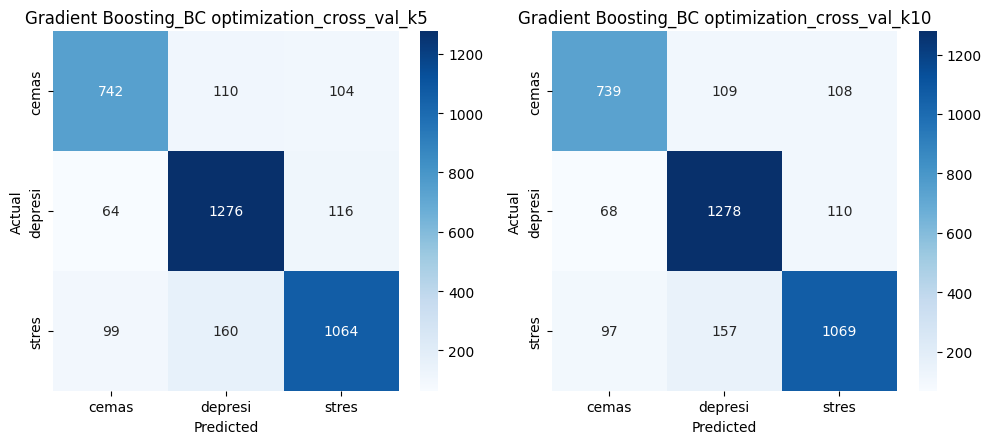

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Set the figure size
plt.rcParams['figure.figsize'] = [20, 25]

# Create subplots for each confusion matrix
for i, (key, value) in enumerate(results.items()):
    # if i >= 20:  # Limit to 20 subplots (5 rows x 4 columns)
    #     break
    cm = np.array(value['confusion_matrix'])
    plt.subplot(6, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(key)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.axis("on")

# Show the plots
plt.tight_layout()
plt.show()

### Evaluasi kinerja model

In [ ]:
# Inisialisasi list untuk menyimpan data
data = []

# Ekstrak split dan model dari keys di results
for key, value in results.items():
    model_name, split_info = key.split(f'_k')
    split_ratio = split_info.replace('cross_val_', '')
    accuracy = value['accuracy']

    # Tambahkan data ke dalam list
    data.append([split_ratio, model_name, accuracy])

# Konversi list ke DataFrame
accuracy_table = pd.DataFrame(data, columns=['K-Fold', 'Model', 'Accuracy'])

# Pivot DataFrame agar model menjadi kolom
accuracy_table = accuracy_table.pivot(index='K-Fold', columns='Model', values='Accuracy')

# Rename columns to remove the extra text
accuracy_table.columns = accuracy_table.columns.str.replace('_BC optimization_cross_val', '')

# Atur ulang kolom sesuai urutan yang diinginkan
accuracy_table = accuracy_table[['Gradient Boosting']]

# Tampilkan tabel akurasi
accuracy_table

Model,Gradient Boosting
K-Fold,
10,0.826238
5,0.825167


In [ ]:
# Initialize an empty list to store data for the DataFrame
data = []

# Extracting data for each model and split
for experiment_name, result in results.items():
    for label, metrics in result['classification_report'].items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip overall metrics
            row = {
                'Experiment': experiment_name,
                'Label': label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            }
            data.append(row)

# Create DataFrame from the data list
df_results = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df_results

,Experiment,Label,Precision,Recall,F1-Score,Support
0,Gradient Boosting_BC optimization_cross_val_k5,cemas,0.819890,0.776151,0.797421,956.0
1,Gradient Boosting_BC optimization_cross_val_k5,depresi,0.825356,0.876374,0.850100,1456.0
2,Gradient Boosting_BC optimization_cross_val_k5,stres,0.828660,0.804233,0.816264,1323.0
3,Gradient Boosting_BC optimization_cross_val_k10,cemas,0.817478,0.773013,0.794624,956.0
4,Gradient Boosting_BC optimization_cross_val_k10,depresi,0.827720,0.877747,0.852000,1456.0
5,Gradient Boosting_BC optimization_cross_val_k10,stres,0.830614,0.808012,0.819157,1323.0


### Simpan ke Excel

In [ ]:
import pandas as pd
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Initialize an empty DataFrame to store all confusion matrices
df_cm_combined = pd.DataFrame()

# Loop through each model and its confusion matrix in the results
for key, value in results.items():
    # Extract the confusion matrix
    cm = np.array(value['confusion_matrix'])

    # Create a DataFrame from the confusion matrix
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)

    # Insert the model name into the first column, with only the first row showing the model name
    df_cm.insert(0, 'Model', [key] + [''] * (len(labels) - 1))

    # Concatenate this confusion matrix DataFrame with the combined DataFrame
    df_cm_combined = pd.concat([df_cm_combined, df_cm])

# Display the combined DataFrame
df_cm_combined

,Model,cemas,depresi,stres
cemas,Gradient Boosting_BC optimization_cross_val_k5,742,110,104
depresi,,64,1276,116
stres,,99,160,1064
cemas,Gradient Boosting_BC optimization_cross_val_k10,739,109,108
depresi,,68,1278,110
stres,,97,157,1069


In [ ]:
# Group by 'Experiment' and calculate the mean of only the numeric columns
df_overall_result = df_results.groupby('Experiment')[['Precision', 'Recall', 'F1-Score']].mean().reset_index()

# Display the overall result DataFrame
df_overall_result

,Experiment,Precision,Recall,F1-Score
0,Gradient Boosting_BC optimization_cross_val_k10,0.825271,0.819591,0.821927
1,Gradient Boosting_BC optimization_cross_val_k5,0.824635,0.818919,0.821262


In [ ]:
# Variabel untuk menyimpan kode sheet
prefix = 'BC'
suffix = 'CV'

# Initialize a Pandas Excel writer
with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a') as writer:
    # Save the accuracy table
    accuracy_table.to_excel(writer, sheet_name=f'{prefix} {suffix} A')

    # Save the combined confusion matrix DataFrame
    df_cm_combined.to_excel(writer, sheet_name=f'{prefix} {suffix} CM')

    # Save the df_results DataFrame
    df_results.to_excel(writer, sheet_name=f'{prefix} {suffix} R')

    # Save the overall results DataFrame
    df_overall_result.to_excel(writer, sheet_name=f'{prefix} {suffix} OR')

# GA SplitV modelling

In [ ]:
models = {
    'Gradient Boosting': GradientBoostingClassifier()
}
optimasi = 'GA optimization'

In [ ]:
splits = [(0.6, 0.4), (0.7, 0.3), (0.8, 0.2), (0.9, 0.1)]
results = {}

def get_ga_search(model):
    param_grids = {
        'GradientBoostingClassifier': { 'n_estimators': Integer(100, 200), 'learning_rate': Continuous(0.1, 0.2)}
    }

    model_name = type(model).__name__
    if model_name not in param_grids:
        raise ValueError(f"Parameter grid for {model_name} not defined")

    ga_search = GASearchCV(
        estimator=model,
        param_grid=param_grids[type(model).__name__],
        scoring='accuracy',
        cv=3,
        n_jobs=-1,
        verbose=True,
        population_size=20,
        generations=4
    )
    return ga_search

In [ ]:
for train_size, test_size in splits:
    print(f'Processing split {int(train_size*100)}:{int(test_size*100)}')

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(fitur, y, test_size=test_size, random_state=42)

    # Subset data dari X_train dan y_train
    X_subset, _, y_subset, _ = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

    for model_name, model in models.items():
        print(f'  Training {model_name} with GASearchCV on subset data')

        # Create GASearchCV with the current model
        ga_search = get_ga_search(model)

        # Fit model using subset data
        ga_search.fit(X_subset, y_subset)
        y_pred = ga_search.predict(X_test)

        # Evaluation
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)

        # Convert tuple key to string
        result_key = f"{model_name}_{optimasi}_split {int(train_size*100)}:{int(test_size*100)}"

        # Save results
        results[result_key] = {
            'best_params': ga_search.best_params_,
            'confusion_matrix': conf_matrix.tolist(),
            'classification_report': class_report,
            'accuracy': accuracy
        }

        print(f'    Accuracy: {accuracy:.4f}')
        print('    Best Params:', ga_search.best_params_)
        print('    Classification Report:')
        print(classification_report(y_test, y_pred, zero_division=0))

# Save results to a JSON file
with open(path + f'{nama_ekstraksi}_ga_sv_experiment_results.json', 'w') as f:
    json.dump(results, f, indent=4)

Processing split 60:40
  Training Gradient Boosting with GASearchCV on subset data
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	0.786028	0.00417148 	0.794643   	0.777681   
1  	40    	0.788929	0.00231787 	0.794643   	0.78483    
2  	40    	0.790092	0.00270791 	0.795542   	0.784818   
3  	40    	0.791654	0.00282698 	0.795535   	0.785714   
4  	40    	0.793396	0.00241719 	0.797324   	0.787504   
    Accuracy: 0.8146
    Best Params: {'n_estimators': 108, 'learning_rate': 0.11357226554113253}
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.82      0.73      0.78       397
     depresi       0.81      0.86      0.83       591
       stres       0.81      0.83      0.82       506

    accuracy                           0.81      1494
   macro avg       0.82      0.81      0.81      1494
weighted avg       0.81      0.81      0.81      1494

Processing split 70:30
  Training Gradient Boosting with GASearchCV on subs

## Menampilkan hasil model

In [ ]:
import json

# Membaca file JSON
with open(path + f'{nama_ekstraksi}_ga_sv_experiment_results.json', 'r') as f:
    results = json.load(f)

### Confusion Matrix (heatmap)

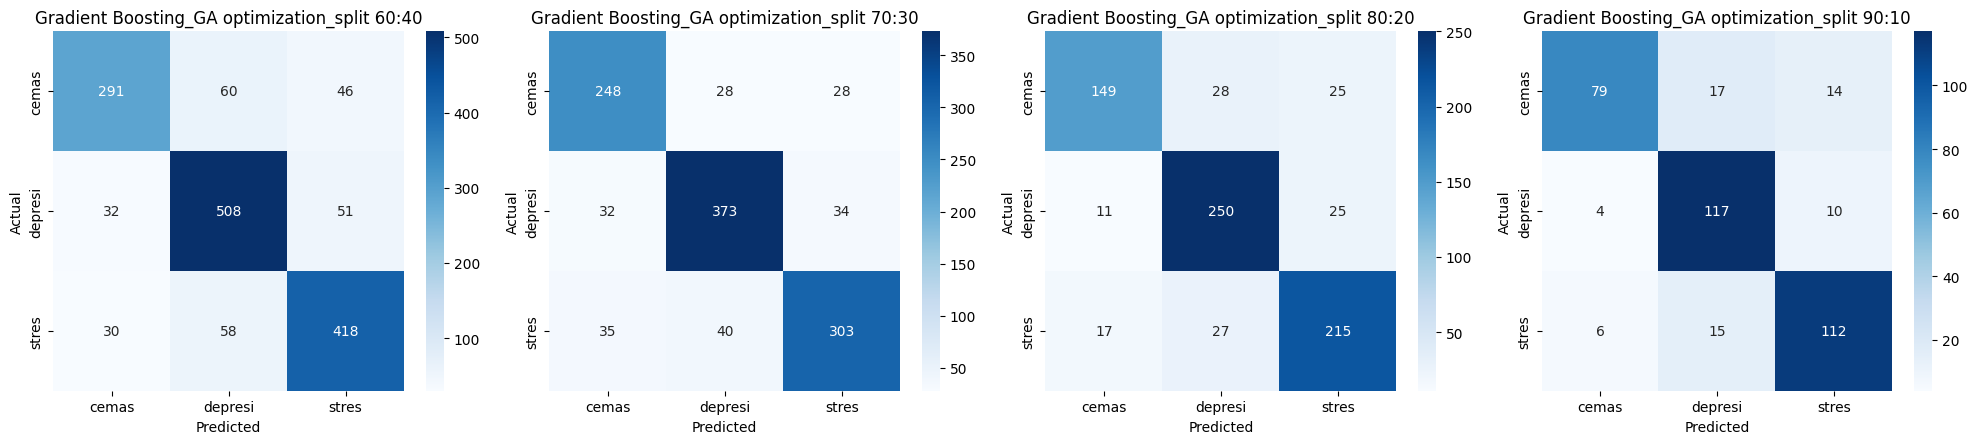

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Set the figure size
plt.rcParams['figure.figsize'] = [20, 25]

# Create subplots for each confusion matrix
for i, (key, value) in enumerate(results.items()):
    cm = np.array(value['confusion_matrix'])
    plt.subplot(6, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(key)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.axis("on")

# Show the plots
plt.tight_layout()
plt.show()

### Evaluasi kinerja model

In [ ]:
# Inisialisasi list untuk menyimpan data
data = []

# Ekstrak split dan model dari keys di results
for key, value in results.items():
    model_name, split_info = key.split(f'_split ')
    split_ratio = split_info.replace('split ', '')
    accuracy = value['accuracy']

    # Tambahkan data ke dalam list
    data.append([split_ratio, model_name, accuracy])

# Konversi list ke DataFrame
accuracy_table = pd.DataFrame(data, columns=['Split', 'Model', 'Accuracy'])

# Pivot DataFrame agar model menjadi kolom
accuracy_table = accuracy_table.pivot(index='Split', columns='Model', values='Accuracy')

# Rename columns to remove the extra text
accuracy_table.columns = accuracy_table.columns.str.replace('_GA optimization', '')

# Atur ulang kolom sesuai urutan yang diinginkan
accuracy_table = accuracy_table[['Gradient Boosting']]

# Tampilkan tabel akurasi
accuracy_table

Model,Gradient Boosting
Split,
60:40,0.814592
70:30,0.824264
80:20,0.821954
90:10,0.823529


In [ ]:
print(accuracy_table.columns)

Index(['Gradient Boosting'], dtype='object', name='Model')


In [ ]:
# Initialize an empty list to store data for the DataFrame
data = []

# Extracting data for each model and split
for experiment_name, result in results.items():
    for label, metrics in result['classification_report'].items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip overall metrics
            row = {
                'Experiment': experiment_name,
                'Label': label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            }
            data.append(row)

# Create DataFrame from the data list
df_results = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df_results

,Experiment,Label,Precision,Recall,F1-Score,Support
0,Gradient Boosting_GA optimization_split 60:40,cemas,0.824363,0.732997,0.776000,397.0
1,Gradient Boosting_GA optimization_split 60:40,depresi,0.811502,0.859560,0.834840,591.0
2,Gradient Boosting_GA optimization_split 60:40,stres,0.811650,0.826087,0.818805,506.0
3,Gradient Boosting_GA optimization_split 70:30,cemas,0.787302,0.815789,0.801292,304.0
4,Gradient Boosting_GA optimization_split 70:30,depresi,0.845805,0.849658,0.847727,439.0
5,Gradient Boosting_GA optimization_split 70:30,stres,0.830137,0.801587,0.815612,378.0
6,Gradient Boosting_GA optimization_split 80:20,cemas,0.841808,0.737624,0.786280,202.0
7,Gradient Boosting_GA optimization_split 80:20,depresi,0.819672,0.874126,0.846024,286.0
8,Gradient Boosting_GA optimization_split 80:20,stres,0.811321,0.830116,0.820611,259.0
9,Gradient Boosting_GA optimization_split 90:10,cemas,0.887640,0.718182,0.793970,110.0


### Simpan ke Excel

In [ ]:
import pandas as pd
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Initialize an empty DataFrame to store all confusion matrices
df_cm_combined = pd.DataFrame()

# Loop through each model and its confusion matrix in the results
for key, value in results.items():
    # Extract the confusion matrix
    cm = np.array(value['confusion_matrix'])

    # Create a DataFrame from the confusion matrix
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)

    # Insert the model name into the first column, with only the first row showing the model name
    df_cm.insert(0, 'Model', [key] + [''] * (len(labels) - 1))

    # Concatenate this confusion matrix DataFrame with the combined DataFrame
    df_cm_combined = pd.concat([df_cm_combined, df_cm])

# Display the combined DataFrame
df_cm_combined

,Model,cemas,depresi,stres
cemas,Gradient Boosting_GA optimization_split 60:40,291,60,46
depresi,,32,508,51
stres,,30,58,418
cemas,Gradient Boosting_GA optimization_split 70:30,248,28,28
depresi,,32,373,34
stres,,35,40,303
cemas,Gradient Boosting_GA optimization_split 80:20,149,28,25
depresi,,11,250,25
stres,,17,27,215
cemas,Gradient Boosting_GA optimization_split 90:10,79,17,14


In [ ]:
# Group by 'Experiment' and calculate the mean of only the numeric columns
df_overall_result = df_results.groupby('Experiment')[['Precision', 'Recall', 'F1-Score']].mean().reset_index()

# Display the overall result DataFrame
df_overall_result

,Experiment,Precision,Recall,F1-Score
0,Gradient Boosting_GA optimization_split 60:40,0.815838,0.806215,0.809882
1,Gradient Boosting_GA optimization_split 70:30,0.821081,0.822345,0.821544
2,Gradient Boosting_GA optimization_split 80:20,0.824267,0.813955,0.817638
3,Gradient Boosting_GA optimization_split 90:10,0.832135,0.817806,0.820799


In [ ]:
# Variabel untuk menyimpan kode sheet
prefix = 'GA'
suffix = 'SV'

# Initialize a Pandas Excel writer
with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a') as writer:
    # Save the accuracy table
    accuracy_table.to_excel(writer, sheet_name=f'{prefix} {suffix} A')

    # Save the combined confusion matrix DataFrame
    df_cm_combined.to_excel(writer, sheet_name=f'{prefix} {suffix} CM')

    # Save the df_results DataFrame
    df_results.to_excel(writer, sheet_name=f'{prefix} {suffix} R')

    # Save the overall results DataFrame
    df_overall_result.to_excel(writer, sheet_name=f'{prefix} {suffix} OR')

# GA CrossV modelling

In [ ]:
models = {
    'Gradient Boosting': GradientBoostingClassifier()
}
optimasi = 'GA optimization'

In [ ]:
def get_ga_search(model):
    param_grids = {
        'GradientBoostingClassifier': { 'n_estimators': Integer(100, 200), 'learning_rate': Continuous(0.1, 0.2)}
    }

    model_name = type(model).__name__
    if model_name not in param_grids:
        raise ValueError(f"Parameter grid for {model_name} not defined")

    ga_search = GASearchCV(
        estimator=model,
        param_grid=param_grids[type(model).__name__],
        scoring='accuracy',
        cv=3,
        n_jobs=-1,
        verbose=True,
        population_size=20,
        generations=4
    )
    return ga_search

In [ ]:
# Nilai k untuk Cross Validation
k_values = [5, 10]
subset_fraction = 0.5

results = {}

for k in k_values:
    for model_name, model in models.items():
        print(f'Training {model_name} with GASearchCV on subset data and Cross Validation (k={k})')

        # Buat subset data untuk GA
        X_subset, _, y_subset, _ = train_test_split(fitur, y, test_size=(1 - subset_fraction), random_state=42)

        # Create GASearchCV with the current model
        ga_search = get_ga_search(model)
        ga_search.fit(fitur, y)

        # Cross validation predictions with k-fold
        y_pred = cross_val_predict(ga_search.best_estimator_, fitur, y, cv=k)

        # Evaluation
        conf_matrix = confusion_matrix(y, y_pred)
        class_report = classification_report(y, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y, y_pred)

        # Convert model name and k value to a valid JSON key
        result_key = f"{model_name}_{optimasi}_cross_val_k{k}"

        # Save results
        results[result_key] = {
            'best_params': ga_search.best_params_,
            'confusion_matrix': conf_matrix.tolist(),
            'classification_report': class_report,
            'accuracy': accuracy
        }

        print(f'    Accuracy: {accuracy:.4f}')
        print('    Best Params:', ga_search.best_params_)
        print('    Classification Report:')
        print(classification_report(y, y_pred, zero_division=0))

# Save results to a JSON file
with open(path + f'{nama_ekstraksi}_ga_cv_experiment_results.json', 'w') as f:
    json.dump(results, f, indent=4)

Training Gradient Boosting with GASearchCV on subset data and Cross Validation (k=5)
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	0.818916	0.00166186 	0.822222   	0.814726   
1  	40    	0.821258	0.00161843 	0.823829   	0.818206   
2  	40    	0.822303	0.0010612  	0.823829   	0.820616   
3  	40    	0.82257 	0.00108128 	0.823829   	0.820616   
4  	40    	0.823387	0.000550492	0.823829   	0.821954   
    Accuracy: 0.8233
    Best Params: {'n_estimators': 115, 'learning_rate': 0.11479143524091162}
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.82      0.78      0.79       956
     depresi       0.83      0.87      0.85      1456
       stres       0.83      0.80      0.81      1323

    accuracy                           0.82      3735
   macro avg       0.82      0.82      0.82      3735
weighted avg       0.82      0.82      0.82      3735

Training Gradient Boosting with GASearchCV on subset data and Cross Valid

## Menampilkan hasil model

In [ ]:
import json

# Membaca file JSON
with open(path + f'{nama_ekstraksi}_ga_cv_experiment_results.json', 'r') as f:
    results = json.load(f)

### Confusion Matrix (heatmap)

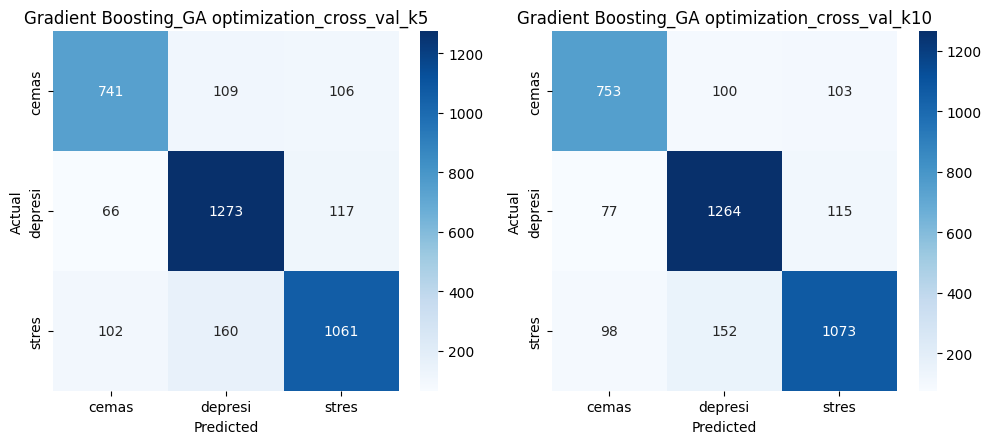

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Set the figure size
plt.rcParams['figure.figsize'] = [20, 25]

# Create subplots for each confusion matrix
for i, (key, value) in enumerate(results.items()):
    cm = np.array(value['confusion_matrix'])
    plt.subplot(6, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(key)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.axis("on")

# Show the plots
plt.tight_layout()
plt.show()

### Evaluasi kinerja model

In [ ]:
# Inisialisasi list untuk menyimpan data
data = []

# Ekstrak split dan model dari keys di results
for key, value in results.items():
    model_name, split_info = key.split(f'_k')
    split_ratio = split_info.replace('cross_val_', '')
    accuracy = value['accuracy']

    # Tambahkan data ke dalam list
    data.append([split_ratio, model_name, accuracy])

# Konversi list ke DataFrame
accuracy_table = pd.DataFrame(data, columns=['Split', 'Model', 'Accuracy'])

# Pivot DataFrame agar model menjadi kolom
accuracy_table = accuracy_table.pivot(index='Split', columns='Model', values='Accuracy')

# Rename columns to remove the extra text
accuracy_table.columns = accuracy_table.columns.str.replace('_GA optimization_cross_val', '')

# Atur ulang kolom sesuai urutan yang diinginkan
accuracy_table = accuracy_table[['Gradient Boosting']]

# Tampilkan tabel akurasi
accuracy_table

Model,Gradient Boosting
Split,
10,0.827309
5,0.823293


In [ ]:
print(accuracy_table.columns)

Index(['Gradient Boosting'], dtype='object', name='Model')


In [ ]:
# Initialize an empty list to store data for the DataFrame
data = []

# Extracting data for each model and split
for experiment_name, result in results.items():
    for label, metrics in result['classification_report'].items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip overall metrics
            row = {
                'Experiment': experiment_name,
                'Label': label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            }
            data.append(row)

# Create DataFrame from the data list
df_results = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df_results

,Experiment,Label,Precision,Recall,F1-Score,Support
0,Gradient Boosting_GA optimization_cross_val_k5,cemas,0.815182,0.775105,0.794638,956.0
1,Gradient Boosting_GA optimization_cross_val_k5,depresi,0.825551,0.874313,0.849233,1456.0
2,Gradient Boosting_GA optimization_cross_val_k5,stres,0.826324,0.801965,0.813962,1323.0
3,Gradient Boosting_GA optimization_cross_val_k10,cemas,0.811422,0.787657,0.799363,956.0
4,Gradient Boosting_GA optimization_cross_val_k10,depresi,0.833773,0.868132,0.850606,1456.0
5,Gradient Boosting_GA optimization_cross_val_k10,stres,0.831139,0.811036,0.820964,1323.0


### Simpan ke Excel

In [ ]:
import pandas as pd
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Initialize an empty DataFrame to store all confusion matrices
df_cm_combined = pd.DataFrame()

# Loop through each model and its confusion matrix in the results
for key, value in results.items():
    # Extract the confusion matrix
    cm = np.array(value['confusion_matrix'])

    # Create a DataFrame from the confusion matrix
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)

    # Insert the model name into the first column, with only the first row showing the model name
    df_cm.insert(0, 'Model', [key] + [''] * (len(labels) - 1))

    # Concatenate this confusion matrix DataFrame with the combined DataFrame
    df_cm_combined = pd.concat([df_cm_combined, df_cm])

# Display the combined DataFrame
df_cm_combined

,Model,cemas,depresi,stres
cemas,Gradient Boosting_GA optimization_cross_val_k5,741,109,106
depresi,,66,1273,117
stres,,102,160,1061
cemas,Gradient Boosting_GA optimization_cross_val_k10,753,100,103
depresi,,77,1264,115
stres,,98,152,1073


In [ ]:
# Group by 'Experiment' and calculate the mean of only the numeric columns
df_overall_result = df_results.groupby('Experiment')[['Precision', 'Recall', 'F1-Score']].mean().reset_index()

# Display the overall result DataFrame
df_overall_result

,Experiment,Precision,Recall,F1-Score
0,Gradient Boosting_GA optimization_cross_val_k10,0.825445,0.822275,0.823644
1,Gradient Boosting_GA optimization_cross_val_k5,0.822352,0.817128,0.819278


In [ ]:
# Variabel untuk menyimpan kode sheet
prefix = 'GA'
suffix = 'CV'

# Initialize a Pandas Excel writer
with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a') as writer:
    # Save the accuracy table
    accuracy_table.to_excel(writer, sheet_name=f'{prefix} {suffix} A')

    # Save the combined confusion matrix DataFrame
    df_cm_combined.to_excel(writer, sheet_name=f'{prefix} {suffix} CM')

    # Save the df_results DataFrame
    df_results.to_excel(writer, sheet_name=f'{prefix} {suffix} R')

    # Save the overall results DataFrame
    df_overall_result.to_excel(writer, sheet_name=f'{prefix} {suffix} OR')

# Basic Split Validation Modelling (tanpa optimasi)

In [ ]:
# Define models
models = {
    'Gradient Boosting': GradientBoostingClassifier()
}

# Define split ratios
splits = [(0.6, 0.4), (0.7, 0.3), (0.8, 0.2), (0.9, 0.1)]

# Initialize results dictionary
results = {}

for train_size, test_size in splits:
    print(f'Processing split {int(train_size*100)}:{int(test_size*100)}')

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(fitur, y, test_size=test_size, random_state=42)

    for model_name, model in models.items():
        print(f'  Training {model_name} (basic model)')

        # Train the model directly
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Evaluation
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)

        # Convert tuple key to string
        result_key = f"{model_name}_basic_split {int(train_size*100)}:{int(test_size*100)}"

        # Save results
        results[result_key] = {
            'confusion_matrix': conf_matrix.tolist(),
            'classification_report': class_report,
            'accuracy': accuracy
        }

        print(f'    Accuracy: {accuracy:.4f}')
        print('    Classification Report:')
        print(classification_report(y_test, y_pred, zero_division=0))

# Save results to a JSON file
with open(path + f'{nama_ekstraksi}_basic_sv_experiment_results.json', 'w') as f:
    json.dump(results, f, indent=4)

Processing split 60:40
  Training Gradient Boosting (basic model)
    Accuracy: 0.8333
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.83      0.78      0.80       397
     depresi       0.83      0.87      0.85       591
       stres       0.83      0.83      0.83       506

    accuracy                           0.83      1494
   macro avg       0.83      0.83      0.83      1494
weighted avg       0.83      0.83      0.83      1494

Processing split 70:30
  Training Gradient Boosting (basic model)
    Accuracy: 0.8403
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.82      0.79      0.81       304
     depresi       0.85      0.88      0.86       439
       stres       0.84      0.84      0.84       378

    accuracy                           0.84      1121
   macro avg       0.84      0.84      0.84      1121
weighted avg       0.84      0.84      0.84      1121

Processing

## Menampilkan hasil model

In [ ]:
import json

# Membaca file JSON
with open(path + f'{nama_ekstraksi}_basic_sv_experiment_results.json', 'r') as f:
    results = json.load(f)

### Confusion Matrix (heatmap)

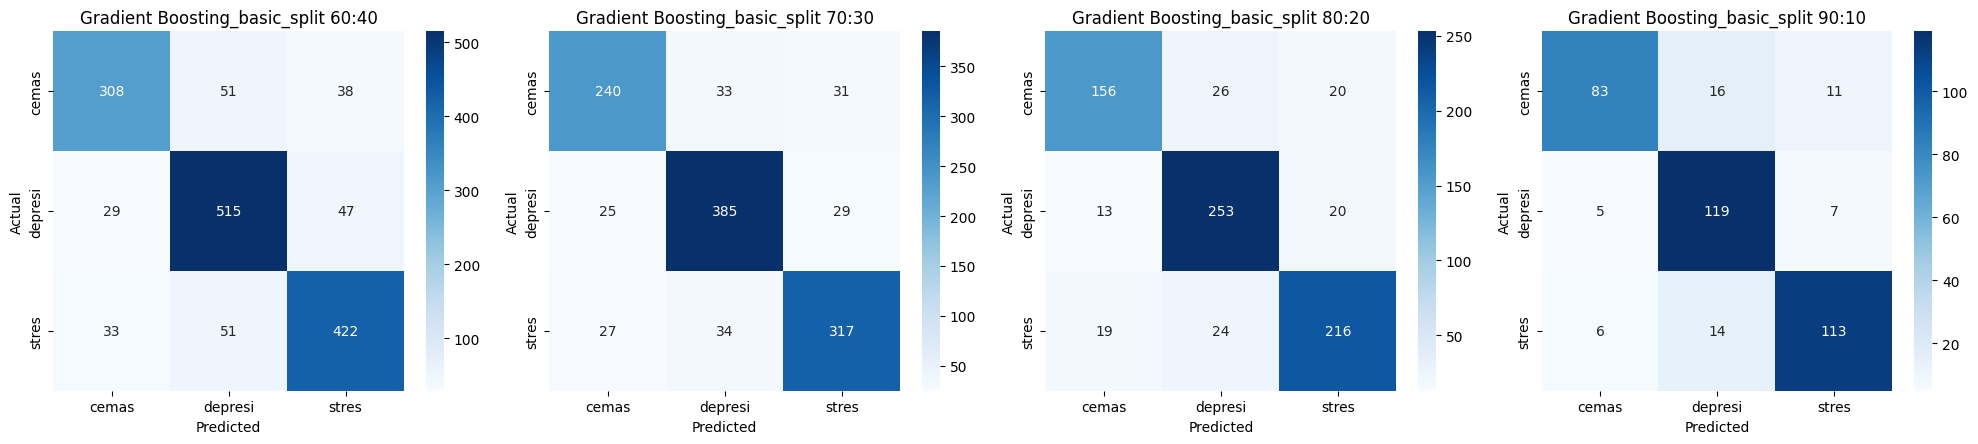

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Set the figure size
plt.rcParams['figure.figsize'] = [20, 25]

# Create subplots for each confusion matrix
for i, (key, value) in enumerate(results.items()):
    cm = np.array(value['confusion_matrix'])
    plt.subplot(6, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(key)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.axis("on")

# Show the plots
plt.tight_layout()
plt.show()

### Evaluasi kinerja model

In [ ]:
# Inisialisasi list untuk menyimpan data
data = []

# Ekstrak split dan model dari keys di results
for key, value in results.items():
    model_name, split_info = key.split(f'_basic_split')
    split_ratio = split_info.replace('_test', ':')
    accuracy = value['accuracy']

    # Tambahkan data ke dalam list
    data.append([split_ratio, model_name, accuracy])

# Konversi list ke DataFrame
accuracy_table = pd.DataFrame(data, columns=['Split', 'Model', 'Accuracy'])

# Pivot DataFrame agar model menjadi kolom
accuracy_table = accuracy_table.pivot(index='Split', columns='Model', values='Accuracy')

# Atur ulang kolom sesuai urutan yang diinginkan
accuracy_table = accuracy_table[['Gradient Boosting']]

# Tampilkan tabel akurasi
accuracy_table

Model,Gradient Boosting
Split,
60:40,0.833333
70:30,0.840321
80:20,0.836680
90:10,0.842246


In [ ]:
# Initialize an empty list to store data for the DataFrame
data = []

# Extracting data for each model and split
for experiment_name, result in results.items():
    for label, metrics in result['classification_report'].items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip overall metrics
            row = {
                'Experiment': experiment_name,
                'Label': label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            }
            data.append(row)

# Create DataFrame from the data list
df_results = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df_results

,Experiment,Label,Precision,Recall,F1-Score,Support
0,Gradient Boosting_basic_split 60:40,cemas,0.832432,0.775819,0.803129,397.0
1,Gradient Boosting_basic_split 60:40,depresi,0.834684,0.871404,0.852649,591.0
2,Gradient Boosting_basic_split 60:40,stres,0.832347,0.833992,0.833169,506.0
3,Gradient Boosting_basic_split 70:30,cemas,0.821918,0.789474,0.805369,304.0
4,Gradient Boosting_basic_split 70:30,depresi,0.851770,0.876993,0.864198,439.0
5,Gradient Boosting_basic_split 70:30,stres,0.840849,0.838624,0.839735,378.0
6,Gradient Boosting_basic_split 80:20,cemas,0.829787,0.772277,0.800000,202.0
7,Gradient Boosting_basic_split 80:20,depresi,0.834983,0.884615,0.859083,286.0
8,Gradient Boosting_basic_split 80:20,stres,0.843750,0.833977,0.838835,259.0
9,Gradient Boosting_basic_split 90:10,cemas,0.882979,0.754545,0.813725,110.0


### Simpan ke Excel

In [ ]:
import pandas as pd
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Initialize an empty DataFrame to store all confusion matrices
df_cm_combined = pd.DataFrame()

# Loop through each model and its confusion matrix in the results
for key, value in results.items():
    # Extract the confusion matrix
    cm = np.array(value['confusion_matrix'])

    # Create a DataFrame from the confusion matrix
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)

    # Insert the model name into the first column, with only the first row showing the model name
    df_cm.insert(0, 'Model', [key] + [''] * (len(labels) - 1))

    # Concatenate this confusion matrix DataFrame with the combined DataFrame
    df_cm_combined = pd.concat([df_cm_combined, df_cm])

# Display the combined DataFrame
df_cm_combined

,Model,cemas,depresi,stres
cemas,Gradient Boosting_basic_split 60:40,308,51,38
depresi,,29,515,47
stres,,33,51,422
cemas,Gradient Boosting_basic_split 70:30,240,33,31
depresi,,25,385,29
stres,,27,34,317
cemas,Gradient Boosting_basic_split 80:20,156,26,20
depresi,,13,253,20
stres,,19,24,216
cemas,Gradient Boosting_basic_split 90:10,83,16,11


In [ ]:
# Group by 'Experiment' and calculate the mean of only the numeric columns
df_overall_result = df_results.groupby('Experiment')[['Precision', 'Recall', 'F1-Score']].mean().reset_index()

# Display the overall result DataFrame
df_overall_result

,Experiment,Precision,Recall,F1-Score
0,Gradient Boosting_basic_split 60:40,0.833155,0.827072,0.829649
1,Gradient Boosting_basic_split 70:30,0.838179,0.835030,0.836434
2,Gradient Boosting_basic_split 80:20,0.836174,0.830290,0.832639
3,Gradient Boosting_basic_split 90:10,0.848077,0.837522,0.839929


In [ ]:
# Variabel untuk menyimpan kode sheet
prefix = 'NAN'
suffix = 'SV'

# Initialize a Pandas Excel writer
with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a') as writer:
    # Save the accuracy table
    accuracy_table.to_excel(writer, sheet_name=f'{prefix} {suffix} A')

    # Save the combined confusion matrix DataFrame
    df_cm_combined.to_excel(writer, sheet_name=f'{prefix} {suffix} CM')

    # Save the df_results DataFrame
    df_results.to_excel(writer, sheet_name=f'{prefix} {suffix} R')

    # Save the overall results DataFrame
    df_overall_result.to_excel(writer, sheet_name=f'{prefix} {suffix} OR')

# Basic Cross Validation Modelling (tanpa optimasi)

In [ ]:
# Define models
models = {
    'Gradient Boosting': GradientBoostingClassifier()
}

# Define cross-validation folds
kf_values = [5, 10]

# Initialize results dictionary
results = {}

for k in kf_values:
    print(f'Processing cross-validation with k={k}')

    for model_name, model in models.items():
        print(f'  Training {model_name} (basic model)')

        # Cross-validation predictions
        y_pred = cross_val_predict(model, fitur, y, cv=k)

        # Evaluation
        conf_matrix = confusion_matrix(y, y_pred)
        class_report = classification_report(y, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y, y_pred)

        # Convert key to string, similar to the split validation
        result_key = f"{model_name}_basic_cross_val_k{k}"

        # Save results in the format similar to split validation
        results[result_key] = {
            'confusion_matrix': conf_matrix.tolist(),
            'classification_report': class_report,
            'accuracy': accuracy
        }

        print(f'    Accuracy: {accuracy:.4f}')
        print('    Classification Report:')
        print(classification_report(y, y_pred, zero_division=0))

# Save results to a JSON file
with open(path + f'{nama_ekstraksi}_basic_cv_experiment_results.json', 'w') as f:
    json.dump(results, f, indent=4)

Processing cross-validation with k=5
  Training Gradient Boosting (basic model)
    Accuracy: 0.8228
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.82      0.78      0.80       956
     depresi       0.82      0.87      0.85      1456
       stres       0.83      0.81      0.82      1323

    accuracy                           0.82      3735
   macro avg       0.82      0.82      0.82      3735
weighted avg       0.82      0.82      0.82      3735

Processing cross-validation with k=10
  Training Gradient Boosting (basic model)
    Accuracy: 0.8241
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.82      0.78      0.80       956
     depresi       0.83      0.87      0.85      1456
       stres       0.82      0.81      0.82      1323

    accuracy                           0.82      3735
   macro avg       0.82      0.82      0.82      3735
weighted avg       0.82      0.82   

## Menampilkan hasil model

In [ ]:
import json

# Membaca file JSON
with open(path + f'{nama_ekstraksi}_basic_cv_experiment_results.json', 'r') as f:
    results = json.load(f)

### Confusion Matrix (heatmap)

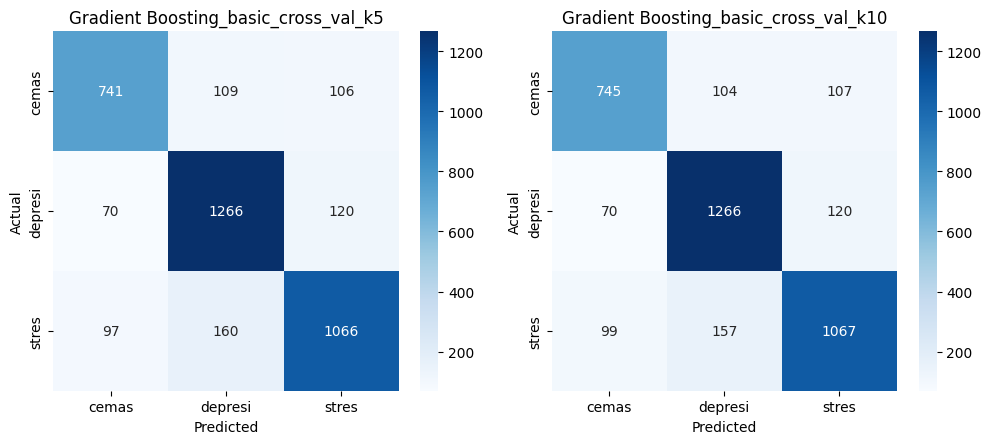

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Set the figure size
plt.rcParams['figure.figsize'] = [20, 25]

# Create subplots for each confusion matrix
for i, (key, value) in enumerate(results.items()):
    # if i >= 20:  # Limit to 20 subplots (5 rows x 4 columns)
    #     break
    cm = np.array(value['confusion_matrix'])
    plt.subplot(6, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(key)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.axis("on")

# Show the plots
plt.tight_layout()
plt.show()

### Evaluasi kinerja model

In [ ]:
# Inisialisasi list untuk menyimpan data
data = []

# Ekstrak split dan model dari keys di results
for key, value in results.items():
    model_name, split_info = key.split(f'_k')
    split_ratio = split_info.replace('cross_val_', '')
    accuracy = value['accuracy']

    # Tambahkan data ke dalam list
    data.append([split_ratio, model_name, accuracy])

# Konversi list ke DataFrame
accuracy_table = pd.DataFrame(data, columns=['K-Fold', 'Model', 'Accuracy'])

# Pivot DataFrame agar model menjadi kolom
accuracy_table = accuracy_table.pivot(index='K-Fold', columns='Model', values='Accuracy')

# Rename columns to remove the extra text
accuracy_table.columns = accuracy_table.columns.str.replace('_basic_cross_val', '')

# Atur ulang kolom sesuai urutan yang diinginkan
accuracy_table = accuracy_table[['Gradient Boosting']]

# Tampilkan tabel akurasi
accuracy_table

Model,Gradient Boosting
K-Fold,
10,0.824096
5,0.822758


In [ ]:
# Initialize an empty list to store data for the DataFrame
data = []

# Extracting data for each model and split
for experiment_name, result in results.items():
    for label, metrics in result['classification_report'].items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip overall metrics
            row = {
                'Experiment': experiment_name,
                'Label': label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            }
            data.append(row)

# Create DataFrame from the data list
df_results = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df_results

,Experiment,Label,Precision,Recall,F1-Score,Support
0,Gradient Boosting_basic_cross_val_k5,cemas,0.816079,0.775105,0.795064,956.0
1,Gradient Boosting_basic_cross_val_k5,depresi,0.824756,0.869505,0.846540,1456.0
2,Gradient Boosting_basic_cross_val_k5,stres,0.825077,0.805745,0.815296,1323.0
3,Gradient Boosting_basic_cross_val_k10,cemas,0.815098,0.779289,0.796791,956.0
4,Gradient Boosting_basic_cross_val_k10,depresi,0.829077,0.869505,0.848810,1456.0
5,Gradient Boosting_basic_cross_val_k10,stres,0.824575,0.806500,0.815438,1323.0


### Simpan ke Excel

In [ ]:
import pandas as pd
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Initialize an empty DataFrame to store all confusion matrices
df_cm_combined = pd.DataFrame()

# Loop through each model and its confusion matrix in the results
for key, value in results.items():
    # Extract the confusion matrix
    cm = np.array(value['confusion_matrix'])

    # Create a DataFrame from the confusion matrix
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)

    # Insert the model name into the first column, with only the first row showing the model name
    df_cm.insert(0, 'Model', [key] + [''] * (len(labels) - 1))

    # Concatenate this confusion matrix DataFrame with the combined DataFrame
    df_cm_combined = pd.concat([df_cm_combined, df_cm])

# Display the combined DataFrame
df_cm_combined

,Model,cemas,depresi,stres
cemas,Gradient Boosting_basic_cross_val_k5,741,109,106
depresi,,70,1266,120
stres,,97,160,1066
cemas,Gradient Boosting_basic_cross_val_k10,745,104,107
depresi,,70,1266,120
stres,,99,157,1067


In [ ]:
# Group by 'Experiment' and calculate the mean of only the numeric columns
df_overall_result = df_results.groupby('Experiment')[['Precision', 'Recall', 'F1-Score']].mean().reset_index()

# Display the overall result DataFrame
df_overall_result

,Experiment,Precision,Recall,F1-Score
0,Gradient Boosting_basic_cross_val_k10,0.822917,0.818432,0.820346
1,Gradient Boosting_basic_cross_val_k5,0.821971,0.816785,0.818967


In [ ]:
# Variabel untuk menyimpan kode sheet
prefix = 'NAN'
suffix = 'CV'

# Initialize a Pandas Excel writer
with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a') as writer:
    # Save the accuracy table
    accuracy_table.to_excel(writer, sheet_name=f'{prefix} {suffix} A')

    # Save the combined confusion matrix DataFrame
    df_cm_combined.to_excel(writer, sheet_name=f'{prefix} {suffix} CM')

    # Save the df_results DataFrame
    df_results.to_excel(writer, sheet_name=f'{prefix} {suffix} R')

    # Save the overall results DataFrame
    df_overall_result.to_excel(writer, sheet_name=f'{prefix} {suffix} OR')